# CS156: Classification of Sunset Images

#### The Data

The aim of this project is to classify photos as 'sunset' or 'not sunset' to determine which images from my camera roll I should post to different Instagram accounts. Though I am not an avid social media participator, I do have two Instagram pages that I use occasionally. One of these is my personal account, where I post photos of me and my friends and family. The other I use to post pictures of sunsets. 

Included in this assignment are 154 photos from my Instagram accounts (55 from my personal account, and 96 from my sunset account) used as training data. I initially wanted to pull these directly from the accounts, however I didn't want to risk my privacy by making them public, and so I settled for downloading the images instead. Also included are 325 photos from my camera roll that were hand-selected by me as photos I would post on one of these Instagram pages (170 of these were non-sunset images, and the other 155 sunsets). The data is located in a google drive folder, separated into training & testing sets, and sunsets & non-sunsets.

#### Converting the Data to Python & Cleaning, Pre-Processing and Feature Engineering

To convert the data into a Python-readable format, we can use the OpenCV package. The method imread loads the images from a local filepath into a numpy array that contains a three-dimensional matrix of integers on the scale [0, 256] that represent the colour intensity of pixels. The first two dimensions represent the location of the pixel in the image, and the third the specific colour intensity (blue, green, and then red for OpenCV).

After loading the data into Python in the code block below, we then resize the images to be 100 by 100 pixels. We do this for a couple of reasons. Firstly, given that there are a lot of images in the datasets of high resolution (lots of pixels), we found that reducing this resolution had a significant impact on the runtime of the algorithm since there were fewer predictors in the model. Secondly, most of the images have different dimensions. Resizing them all to be square allowed each observation to have the same predictors, where one predictor is one coloured pixel.

Some of these resized images are displayed in the code cells below to give an example of the images to classify both from sunset/not sunset groups and testing/training sets. Since OpenCV reads colours in the order BGR, and matplotlib assumes inputs of the format RGB, we can use the method COLOR_BGR2RGB to perform swaps between the pixels.

We then flattened these arrays to produce a one-dimensional array for each image/observation. The coloured pixels were kept as predictors in the model. This is because colour could be an integral factor in identifying an image as a sunset (perhaps my choice of a sunset photo is partly because of the colours in the sky). After flattening the array, each image had $100*100*3=30,000$ predictors.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_images_from_file(paths, show_idxs = []):
    """
    Function retrieves images from local file paths, resizes the images, and flattens them into a 1-dimensional 
    array. The resized images can be displayed using the show_idxs attribute.
    
    Parameters
    ----------
    paths: lst
        List of paths of local files containing images to be read.
    show_idxs: lst
        List of index locations of the resized images to be displayed.
        
    Returns
    -------
    X: lst
        List of numpy arrays of image attributes (integers on scale [0, 256] representing RGB colour intensities for 
        each pixel) taken from resized flattened images.
    y: lst
        List of labels from 0 to len(paths)-1. In the case of binary classification, this is a list of 0s and 1s
        corresponding to the locations of the flattened images in X.
    """
    
    X = []
    y = []
    
    # loops over the paths then filenames where data is located
    for i, path in enumerate(paths):
        for j, filename in enumerate(os.listdir(path)):
            
            # skip over filenames that are not images
            if filename == '.ipynb_checkpoints':
                continue
                
            # read and resize images to 100x100 pixels
            img = cv2.imread(os.path.join(path, filename))
            resized_img = cv2.resize(img, dsize = (100, 100))
            
            # display a portion of loaded resized images
            if j in show_idxs:
                
                # change colour order of images from OpenCV (BGR) -> matplotlib (RBG)
                rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
                plt.matshow(rgb_img)
                plt.show()
            
            # flatten image objects to array of ints on scale [0, 256]
            X.append(resized_img.flatten())
            y.append(i)

    return X, y

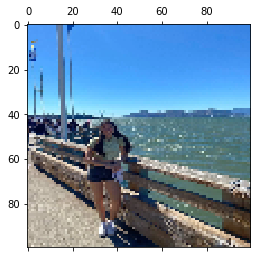

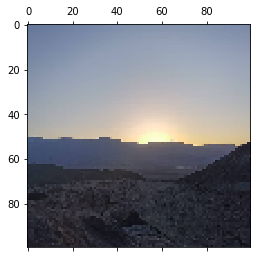

In [2]:
# load training data
path_not_sunsets = "images/CS156/train/not_sunsets"
path_sunsets = "images/CS156/train/sunsets"

X_train, y_train = get_images_from_file([path_not_sunsets, path_sunsets], [30])

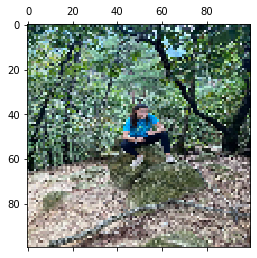

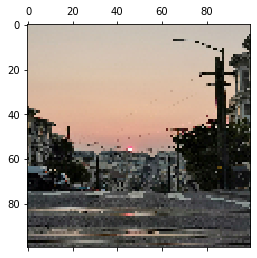

In [3]:
# load testing data
path_not_sunsets = "images/CS156/test/not_sunsets"
path_sunsets = "images/CS156/test/sunsets"

X_test, y_test = get_images_from_file([path_not_sunsets, path_sunsets], [30])

#### The Task: Classification

The tasks here is to classify the images as either sunset or not sunset based on $30,000$ predictors (pixel intensities). Since there are only two categories, this is a binary classification problem.

The test set here is not taken as a random sample from the training data since it will be more valuable to see how the model performs on new data, and to report metrics on a new set of data that represents the models performance on real-world examples. The model will be optimised on the training data using cross validation, and metrics reported on the test data.

#### Model Selection

I will use two different classification models for this task, logistic regression and SVC.

*Logistic Regression*\
Logistic regression works by fitting a sigmoid function to the data as follows:

<ol> 
    <li> Initialise the model parameters:
$weights = [0, 0, ..., 0]$ (one weight for each predictor, initialised to 0) and
$bias = 0$.</li>
    <li> Define the logistic function:
$sigmoid(x) = \frac{1}{1 + e^{-x}}$.</li>
    <li> For each iteration of the training process:
    <ol>
        <li> Calculate the weighted sum of the predictors and the bias:
$z = \sum\limits_{i=1}^{n} weights_i \cdot X_i + bias$, where $n$ is the number of predictors ($30,000$ in this case).</li>
        <li> Pass the weighted sum through the logistic function to get the predicted probability of the image being of a sunset (positive class):
$prediction = sigmoid(z)$.</li>
        <li> Calculate the error between the predicted probability and the actual label:
$error = y - prediction$.</li>
        <li> Update the weights and bias based on the error and a learning rate ($\alpha$):
$weights_i = weights_i + \alpha \cdot error \cdot X_i$ and
$bias = bias + \alpha \cdot error$.</li></ol>
    <li> Repeat step 3 until the model has converged (the error doesn't signficiantly change over a number of iterations) or a maximum number of iterations has been reached.</li>
    <li> After the model has been trained, new data can be input and the predicted probabilities can be calculated using the logistic function and the final weights and bias.</li>
</ol>

In scikit-learn, the logistic regression implementation uses an optimisation algorithm, such as liblinear or lbfgs, to find the optimal weights that minimise the cost function instead of the iterative approach outlined above. This allows for a more efficient and scalable solution, especially when the number of predictors is large as in this case. Additionally, scikit-learn's logistic regression implementation also uses an 'L2' penalty that is added to the cost function to prevent overfitting.

*SVC*\
Support-vector classifications works by creating a hyperplane in high-dimensional space that separates the data belonging to sunset and non-sunset groups as follows:
<ol>
    <li> Initialise the parameter $C$, which determines the trade-off between achieving a low training error and a low testing error, and the kernel function, which transforms the flattened image data into a higher-dimensional space where a linear boundary can better separate the classes, sunset and not sunset.</li>
    <li> Train the SVM model by solving the following optimization problem:
$$\min_{w, b, \xi} \frac{1}{2}|w|^2 + C \sum_{i=1}^{n} \xi_i$$

Subject to the constraints:
$$y_i(w^Tx_i + b) \geq 1 - \xi_i$$
$$\xi_i \geq 0$$

where $w$ is the weight vector, $b$ is the bias term, $\xi_i$ is the slack variable for the $i^{th}$ training example $(x_i, y_i)$, and $C$ is the regularization parameter. The optimization problem is aimed to find the optimal values for $w$, $b$, and $\xi_i$ that maximizes the margin between the hyperplane (defined by $w$ and $b$) and the closest data points (support vectors) while still accommodating some misclassified examples through the use of slack variables.</li>
    <li> Use the obtained hyperplane parameters $w$ and $b$ to make predictions on new data by computing the dot product of the feature representation $\phi(x)$ of a new example $x$ and the weight vector $w$, plus the bias $b$. The sign of the result determines the predicted class label.</li>

#### Training the Model

To train the model, the data is split into five folds, and a grid search is completed to find the optimal classifier (logistic regression versus SVC) and respective parameters. For logistic regression, the hyperparameters to tune include C, a regularisation term to reduce overfitting, and the solver, the algorithm used to find the optimal weights and bias that minimise the cost function. For SVC, the hyperparameters to tune include C (same definition as for logistic regression), and gamma, a parameter that determines the flexibility of the decision boundary.

For each fold, the data is fitted on the remaining four folds, and the test precision is measured on the final fold that was left out. The test performance is given as a mean of these five values. This mean precision is calculated for each set of parameters as above. The cross-validation performed here helps to prevent overfitting by ensuring the model does not tune to specific features of the images that aren't generalisable to all potential images that would be run through the model.

Precision is used in this analysis due to the cost of identifying an image as a sunset when it is not. I don't mind if an image of a sunset is shared on my personal Instagram account (false negative), however sharing an image of myself on my sunset page (false positive), which is public, could severely breach my privacy. I only care about false positives and use precision, which gives the proportion of correctly-classified sunset images to all images that are classified as sunsets, as the optimisation target. 

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV

def logreg_svc_CV(X_train, y_train):
    """
    Completes grid search cross validation on logistic regression models with varying C and solver parameters, and SVC
    with varying C and gamma parameters. For each of 5 folds, the model is fit on 4/5, the other being reserved for 
    measuring precision. GridSearchCV does this for all classifier/parameter combinations and returns an object
    containing the results for each combination, including precisions for each fold of the CV.
    
    Parameters
    ----------
    X_train: lst
        Nested list of predictors for each observation. In the case of sunset classification, this is a list of image 
        attributes (integers on scale [0, 256] representing RGB colour intensities for each pixel).
    y_train: lst
        List of labels, the targets of the classification (0: not sunset, 1: sunset).
        
    Returns
    -------
    gs: GridSearchCV obj
        An object containing the results for each combination, including precisions for each fold of the CV.
    """
    
    # number of folds for CV
    kfold = KFold(n_splits = 5, random_state = 123, shuffle = True)
    
    clf_logreg = LogisticRegression(random_state = 123)
    clf_svc = SVC(random_state = 123)

    # hyperparameters to optimise over for logistic regression
    param_logreg = {
        'classifier': [clf_logreg],
        'classifier__C': np.power(10.0, np.arange(-4, 5)),
        'classifier__solver': ['liblinear', 'lbfgs', 'sag', 'saga']
    }

    # hyperparameters to optimise over for SVC
    param_svc = {
        'classifier': [clf_svc],
        'classifier__C': np.power(10.0, np.arange(-4, 5)),
        'classifier__gamma': np.power(10.0, np.arange(-4, 1))
    }
    
    pipeline = Pipeline([('classifier', clf_logreg)])
    param_grid = [param_logreg, param_svc]

    # fit for different parameters & models, for each of k folds
    gs = GridSearchCV(pipeline, param_grid = param_grid, scoring = 'precision', cv = kfold, n_jobs = -1, verbose = 3)
    gs.fit(X_train, y_train)
    
    print('Best parameters:', gs.best_params_)
    
    return gs

gs = logreg_svc_CV(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'classifier': LogisticRegression(C=100.0, random_state=123), 'classifier__C': 100.0, 'classifier__solver': 'lbfgs'}


Plotting the results as below, we see that logistic regression does a much better job in terms of precision score. The optimal model is the one that uses the default solver 'lbfgs' and a C value of 100.

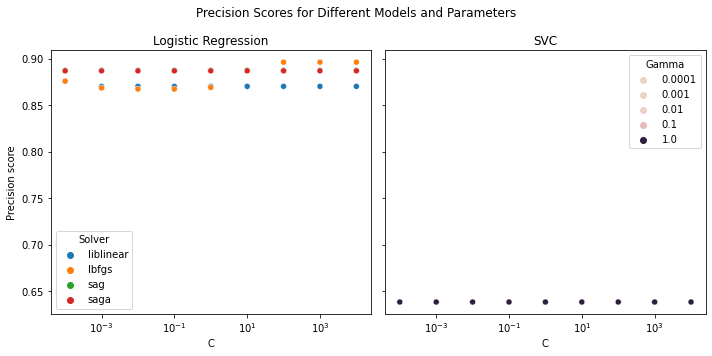

In [5]:
import pandas as pd
import seaborn as sns

def plot_gs_results(df_gs, params1, params2, model1, model2):
    """
    Plots the results of precision scores from gridsearch dataframe. The function creates two subplots, one containing
    the results for the first model based on two chosen parameters, and the other the results of the second model based
    on two chosen parameters (can be the same of different features).
    
    Parameters
    ----------
    df_gs: df
        Dataframe containing the results from a GridSearchCV object.
    params1: lst
        List of parameters to plot on subplot one. The first element of the list is the x axis, the second the y axis, and
        the third the hue.
    params2: lst
        List of parameters to plot on subplot two. The first element of the list is the x axis, the second the y axis, and
        the third the hue.
    model1: str
        The name of the classifier used for subplot one.
    model2: str
        The name of the classifier used for subplot two.
    
    Returns
    -------
    None
    """
    
    # initialise plots and plot params for each model
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
    sns.scatterplot(data = df_gs, x = params1[0], y = params1[1], hue = params1[2], ax = ax[0])
    sns.scatterplot(data = df_gs, x = params2[0], y = params2[1], hue = params2[2], ax = ax[1])
    
    # rescale axis to display C at regular intervals
    ax[0].set_xscale('log')
    ax[1].set_xscale('log')
    ax[0].set_title(model1)
    ax[1].set_title(model2)
    fig.suptitle('Precision Scores for Different Models and Parameters')
    fig.tight_layout()
    plt.show()

# convert grid search results to df, and rename columns for plotting
df_gs = pd.DataFrame(gs.cv_results_)
df_gs.rename(columns={'param_classifier__C':'C', 'mean_test_score':'Precision score', 
                      'param_classifier__solver':'Solver', 'param_classifier__gamma': 'Gamma', 
                      'param_classifier': 'Model'}, inplace=True)

plot_gs_results(df_gs, ['C', 'Precision score', 'Solver'], ['C', 'Precision score', 'Gamma'], 
                'Logistic Regression', 'SVC')

#### Making Predictions and Performance Metrics & Visualisation and Discussion of Results

From the calculations on the test dataset, we get a precision score of 0.774, meaning 77.4% of the images classified as sunsets by the logistic regression model were actually sunset images. The remaining 22.6% were classified as sunsets despite being non-sunsets. Though the classification is not terrible, ideally we want a higher precision score than this given the high cost of making incorrect sunset classifications (false positives). 

The AUC and accuracy scores are higher in this case since the number of false negatives is very low (only 4 out of 325 observations looking at the confusion matrix). We don't give too much attention to these metrics here, but they are printed below for completion. If, for example, I decided to make the sunset Instagram account private as well, posting personal pictures there would not be a problem, and thus we would want to use the AUC score to optimise the model instead. Accuracy in this case is also a fair metric to use since the sunset to non-sunset image ratio is not particularly imbalanced.

Precision score for test set: 0.774
AUC score for test set: 0.858
Accuracy score for test set: 0.852


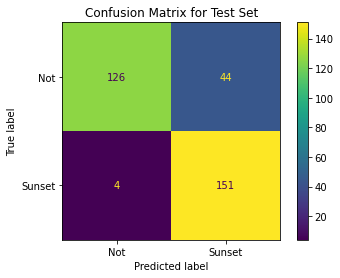

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score

# make predictions from optimal grid search model
y_pred = gs.predict(X_test)

# Precision score for model
print('Precision score for test set:', round(precision_score(y_test, y_pred), 3))

# ROC score for model
print('AUC score for test set:', round(roc_auc_score(y_test, y_pred), 3))

# Accuracy score for model
print('Accuracy score for test set:', round(accuracy_score(y_test, y_pred), 3))

# plot confusion matrix between test set classifications and predictions
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels = ['Not', 'Sunset'])
cmd.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()

#### Executive Summary

*Pipeline*\
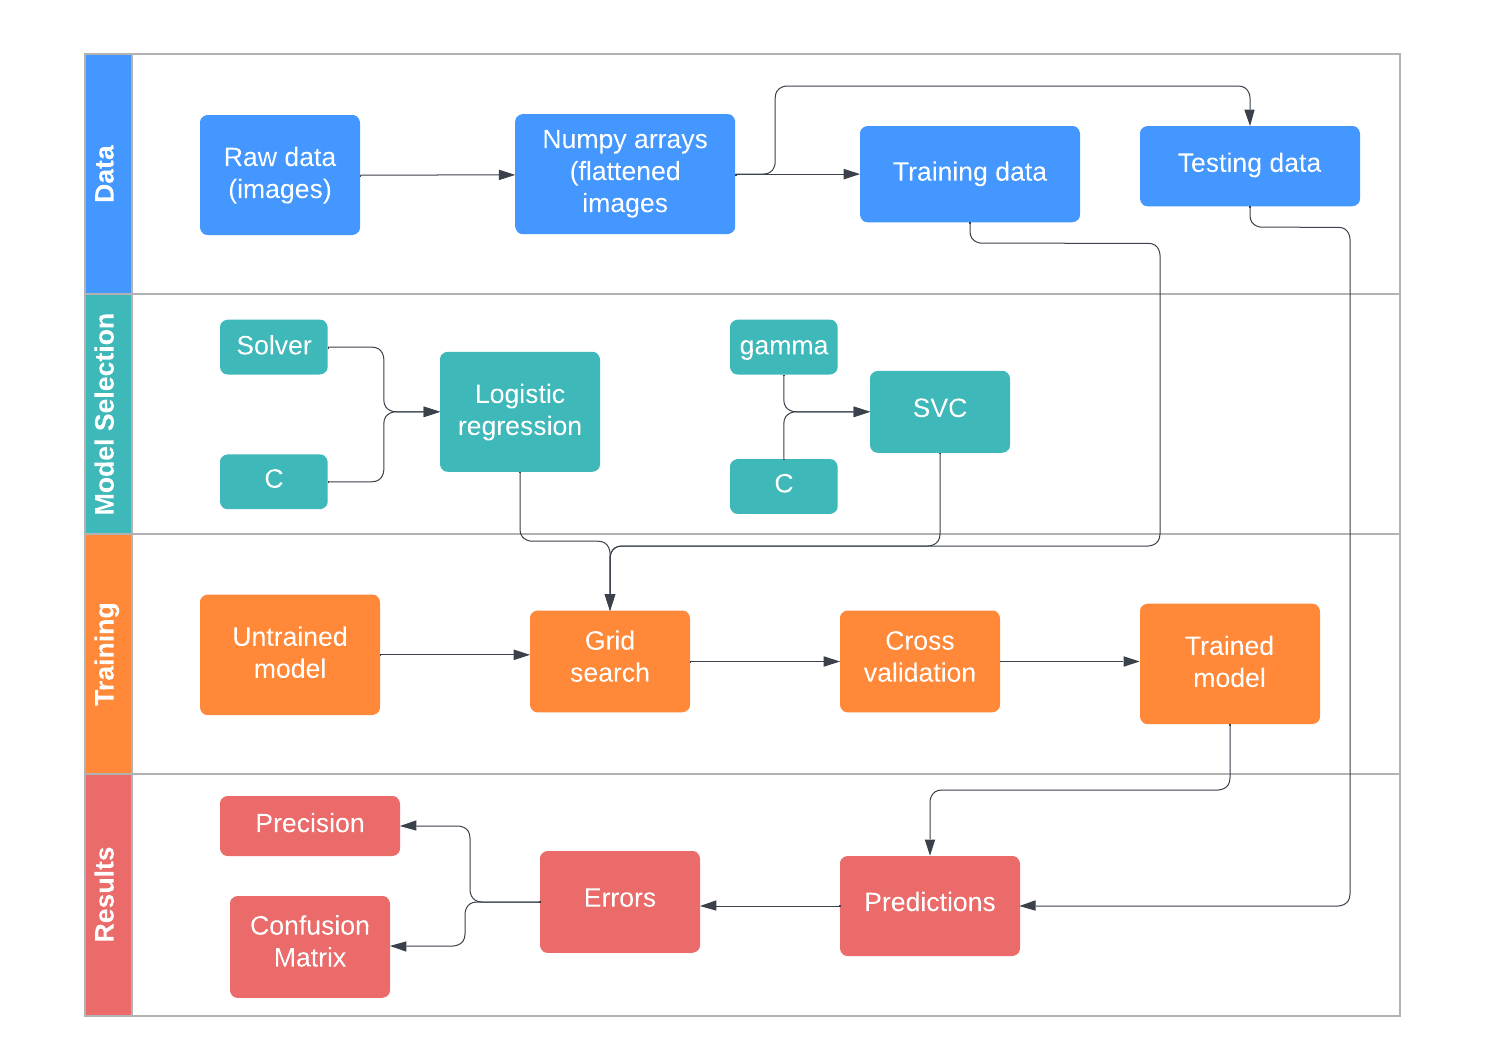

*Summary*\
In this project, we attempted to classify images as 'sunset' or 'not sunset' with the aim of choosing which photos could be posted to two different Instagram accounts. Out of various parameters for both logistic regression and SVM models, it was found that a logistic regression model with parameters C=100 and Solver=lbfgs produced the highest precision score on the training data, using cross-validation as a proxy for the out-of-sample performance. The precision score for the test dataset was found to be 77.4%. The entire pipeline is shown in the flowchart above.

*Improvements*\
There are some improvements that could be made to increase the precision of the model. Firstly, increasing the resolution of the images. 100 by 100 pixels is quite low and might not capture all the small-scale features of the images. Secondly, we might consider other classification models, since both logistic regression and SVM have drawbacks (such as logistic regression constructing linear boundaries). For example, K-nearest neighbours or decision trees would also be applicable to this situation. Finally, the data used here is very high-dimensional and contains many more predictors than observations. This could also impact the model's ability to perform well. We could overcome this by performing PCA and reducing the dimensionality of the data, then rerunning the grid search cross-validation as above.

#### References

Acharya, H. (2017, June 9). Why my image is different being plotted in Opencv-Python? Stack Overflow. [https://stackoverflow.com/questions/44447957/why-my-image-is-different-being-plotted-in-opencv-python](https://stackoverflow.com/questions/44447957/why-my-image-is-different-being-plotted-in-opencv-python) 

Kumar, S. (2021, October 30). How to tune multiple ML models with GridSearchCV at once? Medium; Towards Data Science. [https://towardsdatascience.com/how-to-tune-multiple-ml-models-with-gridsearchcv-at-once-9fcebfcc6c23](https://towardsdatascience.com/how-to-tune-multiple-ml-models-with-gridsearchcv-at-once-9fcebfcc6c23)

Luk, K. (2019, March 30). What libraries can load image in Python and what are their difference? Medium; Towards Data Science. [https://towardsdatascience.com/what-library-can-load-image-in-python-and-what-are-their-difference-d1628c6623ad](https://towardsdatascience.com/what-library-can-load-image-in-python-and-what-are-their-difference-d1628c6623ad)

Scikit-Learn. (2014). sklearn.linear_model.LogisticRegression. Scikit-Learn. [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Scikit-Learn. (2023a). 1.4. Support Vector Machines. Scikit-Learn. [https://scikit-learn.org/stable/modules/svm.html](https://scikit-learn.org/stable/modules/svm.html)

Scikit-Learn. (2023b). sklearn.svm.SVC. Scikit-Learn. [https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.htmlVisually](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.htmlVisually)

Explained. (2021). Support Vector Machine (SVM) in 2 minutes [YouTube Video]. In YouTube. [https://www.youtube.com/watch?v=_YPScrckx28&ab_channel=VisuallyExplained](https://www.youtube.com/watch?v=_YPScrckx28&ab_channel=VisuallyExplained)